In [46]:
import matplotlib.pyplot as plt
import networkx as nx
from scipy import stats
from matplotlib.animation import FuncAnimation
import numpy as np
import time
import os
import random

from epidemic_simulation import get_epidemic_infection_times, import_data, get_epidemic_infection_times_np_array
from best_protection_strategy import get_protection_strategies

In [47]:
# The locations and schedule of movements:
EVENT_FNAME = "data/events_US_air_traffic_GMT.txt"
# Network file of the nodes:
NETWORK = "data/aggregated_US_air_traffic_network_undir.edg"
# Locations and names for the nodes in the visualization:
AIRPORT_INFO_CSV_FNAME = 'data/US_airport_id_info.csv'

# Task 1 : Calculate infections WRT nodes and probabilities

In [48]:
def bin_inf_times(inf_times, bin_times):
    bins_array = []
    for time in bin_times:
        bins = sum(time > inf_times) / len(inf_times)
        bins_array.append(bins)
    return bins_array

def average_infection_times(first_infected_nodes, infection_probability, movement_info, n_iter):
    bins_array = []
    for n in range(n_iter):
        infection_times = get_epidemic_infection_times(first_infected_nodes, infection_probability, movement_info)
        bin_array = bin_inf_times(infection_times, bin_times)
        bins_array.append(bin_array)
    average_bin_array = np.average(bins_array, axis=0)

    return average_bin_array


# task 2: Plot the infections calculated above 

Infection probability: 0.01
Infection probability: 0.05
Infection probability: 0.1
Infection probability: 0.5
Infection probability: 1.0


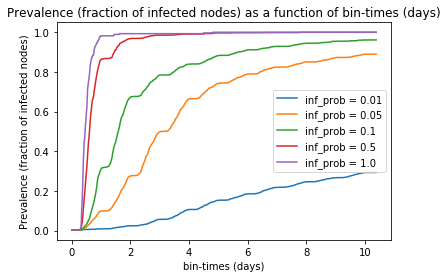

In [49]:
def plot(x, y, x_name, value, y_name='Prevalence (fraction of infected nodes)'):
    understandable_time_format = (x - min(x)) / (60 * 60 * 24)
    time_format = 'days'
    plt.plot(understandable_time_format, y, label=value)
    plt.ylabel(y_name)
    plt.xlabel('{} ({})'.format(x_name, time_format))
    plt.title('{} as a function of {} ({})'.format( y_name, x_name, time_format))
    return


def average_infection_times_for_different_infection_probabilities(movement_info, bin_times, n_iter, inf_probabilities, inf_node):
    # Average infection times for different infection probabilities:
    for inf_prob in inf_probabilities:
        print('Infection probability:', inf_prob)
        average_bin_array = average_infection_times( inf_node, inf_prob, movement_info, n_iter)
        plot(bin_times, average_bin_array, 'bin-times','inf_prob = {}'.format(inf_prob))
    plt.legend()
    plt.show()
    plt.clf()
    return


if __name__ == "__main__":
## Task 1,2:
    ## Average infection times for different infection probabilities:
    n_iter = 10
    inf_probabilities = [0.01, 0.05, 0.1, 0.5, 1.0]
    inf_node = 0
    average_infection_times_for_different_infection_probabilities(movement_info, bin_times, n_iter, inf_probabilities, inf_node)
    

First infected node: 0
First infected node: 4
First infected node: 41
First infected node: 100
First infected node: 200


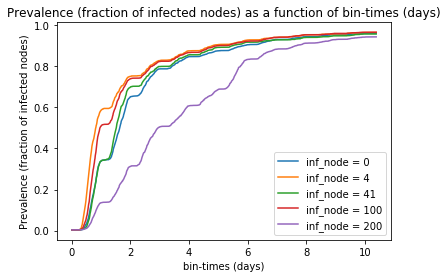

In [50]:
def average_infection_times_for_different_seed_nodes(movement_info, bin_times, n_iter, inf_prob, infected_nodes):
    # Average infection times for different infection seed nodes:
    for inf_node in infected_nodes:
        print('First infected node:', inf_node)
        average_bin_array = average_infection_times(inf_node, inf_prob, movement_info, n_iter)
        plot(bin_times, average_bin_array, 'bin-times','inf_node = {}'.format(inf_node))
    plt.legend()
    plt.show()
    plt.clf()
    return

if __name__ == "__main__":

    movement_info = import_data(EVENT_FNAME)
    movement_info_array = get_np_array_from_tuple_list(movement_info)
    bin_times = np.linspace(min(movement_info['StartTime']), max(movement_info['EndTime']), 1000)
    epidemic_graph = read_undirected_weighted_edgelist(NETWORK)
    
    ## Average infection times for different infection seed nodes:
    n_iter = 10
    inf_prob = 0.1
    infected_nodes = [0, 4, 41, 100, 200]
    average_infection_times_for_different_seed_nodes(movement_info, bin_times, n_iter, inf_prob, infected_nodes)


# Task 3 : calculate the basic metric of graph : closeness,betweeness centrality,degree and clustering coefficient.
##Plot scatter graphs WRT results .

In [51]:
def median_inf_time(inf_prob, movement_info, n_iter):
    infected_nodes = random.sample(range(max(movement_info['Source']) + 1), n_iter)
    times_array = []
    for inf_node in infected_nodes:
        #print('First infected node:', inf_node)
        infection_times = get_epidemic_infection_times(inf_node, inf_prob, movement_info)
        times_array.append(infection_times)
    median_time_array = np.median(times_array, axis=0)
    # Taking away is the "max time" (10000000000)... so it never got infected
    median_time_array[median_time_array == 10000000000] = 0
    return median_time_array


def dict_to_sorted_list(input_dict):
    output_list = []
    for key in sorted(input_dict.keys()):
        output_list.append(input_dict[key])
    return output_list


def scatter(x, y, x_name, y_name='Median infection time'):
    understandable_time_format = (y - min(y)) / (60 * 60 * 24)
    time_format = 'days'
    plt.scatter(x, understandable_time_format)
    correlation, pvalue = stats.spearmanr(x, y)
    print('Correlation between {} and {} is: {}'.format(x_name, y_name, correlation))
    plt.ylabel('{} ({})'.format(y_name, time_format))
    plt.xlabel(x_name)
    plt.title('{} ({}) as a function of {}'.format(y_name, time_format, x_name))
    plt.show()
    plt.clf()
    return


def do_and_scatter_statisticst(movement_info, epidemic_graph):
    # Mean of each node's infection times:
    n_iter = 50
    inf_prob = 0.5
    median_time_array = median_inf_time(inf_prob, movement_info, n_iter)

    # Draw by unweighted clustering coefficient c:
    clustering_dict = nx.clustering(epidemic_graph)
    clustering_list = dict_to_sorted_list(clustering_dict)
    scatter(clustering_list, median_time_array, 'clustering_coefficient')

    # Draw by degree k:
    degree_dict = epidemic_graph.degree()
    degree_list = dict_to_sorted_list(degree_dict)
    scatter(degree_list, median_time_array, 'degree')

    # Draw by betweeness:
    betweenness_dict = nx.betweenness_centrality(epidemic_graph)
    betweenness_list = dict_to_sorted_list(betweenness_dict)
    scatter(betweenness_list, median_time_array, 'betweeness')

    # Draw by closeness:
    closeness_dict = nx.closeness_centrality(epidemic_graph)
    closeness_list = dict_to_sorted_list(closeness_dict)
    scatter(closeness_list, median_time_array, 'closeness_centrality')

    # Draw by the sum of each parameters normalized value:
    degree_array = np.array(degree_list) / max(degree_list)
    betweenness_array = np.array(betweenness_list) / max(betweenness_list)
    closeness_array = np.array(closeness_list) / max(closeness_list)
    data = [ degree_array,betweenness_array, closeness_array]
    data_array = np.array(data)
    sum_data = data_array.sum(axis=0)
    scatter(sum_data, median_time_array, 'normalized_SUM')
    return

Correlation between clustering_coefficient and Median infection time is: -0.14910462683643083


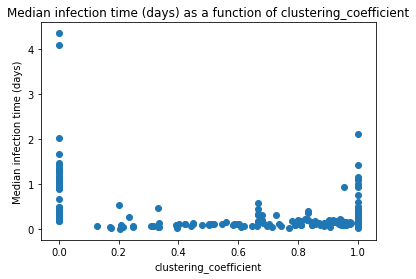

Correlation between degree and Median infection time is: -0.8299664442241789


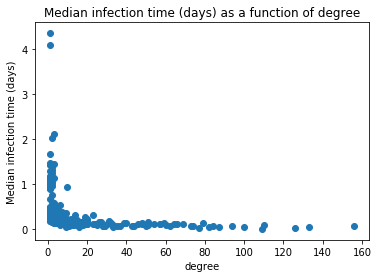

Correlation between betweeness and Median infection time is: -0.6443565277933909


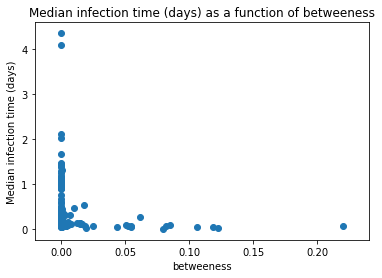

Correlation between closeness_centrality and Median infection time is: -0.8461132605493716


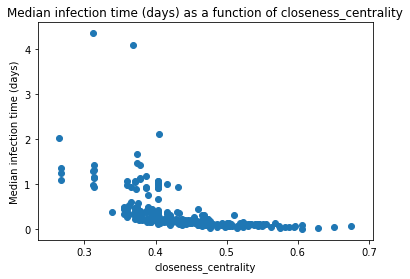

Correlation between normalized_SUM and Median infection time is: -0.851859560683437


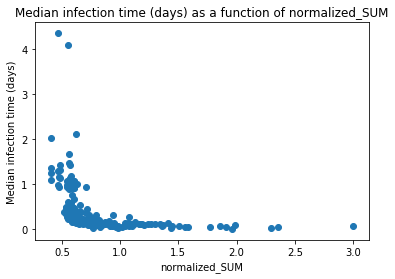

In [42]:
if __name__ == "__main__":
    
## Task 3:
    do_and_scatter_statisticst(movement_info, epidemic_graph)

# Task 4: Prevention of the disease WRT to basic metrics calculated above.

In [52]:
def read_undirected_weighted_edgelist(network):
    network_info = import_data(network)
    network_list = []
    for node_1, node_2, weight in network_info:
        network_list.append('{} {} {}'.format(node_1, node_2, weight))
    epidemic_graph = nx.parse_edgelist(network_list, nodetype=int, data=(('weight', float),))
    return epidemic_graph


def get_average_infection_times_with_different_seeds(inf_prob, movement_info, seed_nodes, immunized_nodes_list):
  bins_array = []
  for seed in seed_nodes:
    inf_times = get_epidemic_infection_times_np_array(seed, inf_prob, movement_info, immunized_nodes_list)
    bin_array = bin_inf_times(inf_times, bin_times)
    bins_array.append(bin_array)
  ave_inf_times = np.average(bins_array, axis=0)
  return ave_inf_times


def get_np_array_from_tuple_list(movement_info):
    movement_info_array = []
    for movement in movement_info:
        row = []
        for mov in movement:
            row.append(mov)
        movement_info_array.append(row)
    movement_info_array = np.array(movement_info_array)
    return movement_info_array


Looking for the best protection strategy...
Different immunization strategies are (with 10 immunized nodes and 20 different seed nodes):
1. random neighbor
2. clustering
3. degree
4. betweenness
5. closeness


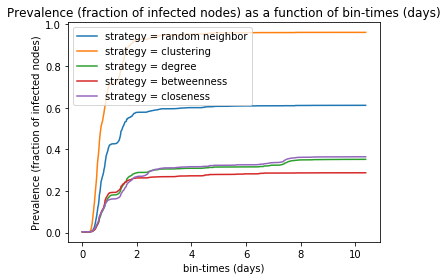

In [53]:
if __name__ == "__main__":

## Task 4:
    print('\nLooking for the best protection strategy...')
    different_strategies, seed_nodes = get_protection_strategies(
        movement_info_array, epidemic_graph)
    ## Average infection times for different immunization strategies and infection seed nodes:
    inf_prob = 0.5
    for strategy in different_strategies:
        #print('\nCalculating infection times with immunized {} nodes...'.format(strategy[2]))
        ## Excluding the infected nodes from the plot:
        #ave_inf_times = get_average_infection_times_with_different_seeds(inf_prob, strategy[1], seed_nodes, [])
        ## Including the infected nodes to the plot:
        ave_inf_times = get_average_infection_times_with_different_seeds(inf_prob, movement_info_array, seed_nodes, strategy[0])
        plot(bin_times, ave_inf_times, 'bin-times',
            'strategy = {}'.format(strategy[2]))
       # print('{} calculated and plotted'.format(strategy[2]))
    plt.tight_layout()
    plt.legend()
    plt.show()
    plt.clf()